In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from validphys.api import API
from validphys.theorycovariance.higher_twist_functions import compute_deltas_pc

from ht_plot_utlis import plot_covmat_heatmap
from ht_utlis import TCM, HTset

In [3]:
fitname = "250120-ac-04-pc-tcm"
thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]
pc_parameters = thcovmat_dict['pc_parameters']
covmat_pdf = thcovmat_dict['pdf']
pc_included_prcs = thcovmat_dict['pc_included_procs']
pc_excluded_exps = thcovmat_dict['pc_excluded_exps']
fitpath = API.fit(fit=fitname).path

Construct the index used to label the parameters used to parameterise the higher twist

In [4]:
ht_names = []
ht_nodes = []
x_nodes = {}
beta_tilde = []
for ht in pc_parameters:
  beta_tilde.append(ht['yshift'])
  x_nodes[ht['ht']] = ht['nodes']
  for idx_node in range(len(ht['yshift'])):
    ht_names.append(ht['ht'])
    ht_nodes.append(ht['ht'] + f"({idx_node})")

beta_tilde = np.concatenate(beta_tilde)

# Compute beta_tilde according to the 5pt prescription
tmp_mat = np.zeros(shape=(len(beta_tilde), len(beta_tilde)))
np.fill_diagonal(tmp_mat, beta_tilde)


ht_index_tuple = list(zip(ht_names, ht_nodes))
ht_index = pd.MultiIndex.from_tuples(ht_index_tuple, names=["HT", "nodes"])
beta_tilde = pd.DataFrame(tmp_mat, index=ht_index, columns=ht_index)

In [5]:
save_dir = f"./Results/{fitname}"
target_dir = Path(save_dir)
pickle_path = Path(save_dir + "/posteriors.pkl")
if not target_dir.is_dir():
  target_dir.mkdir(parents=True, exist_ok=True)

In [6]:
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)

In [7]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

LHAPDF 6.5.4 loading all 201 PDFs in set 250120-ac-04-pc-tcm
250120-ac-04-pc-tcm, version 1; 201 PDF members


In [8]:
preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

In [9]:
# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

### Load theory covmat

In [10]:
### Load power corrections covmat
S = pd.read_csv(
    fitpath / "tables/datacuts_theory_theorycovmatconfig_point_prescriptions0_theory_covmat_custom_per_prescription.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    engine="python",
)
storedcovmat_index = pd.MultiIndex.from_tuples(
    [(aa, bb, np.int64(cc)) for aa, bb, cc in S.index],
    names=["group", "dataset", "id"],
)
S = pd.DataFrame(
    S.values, index=storedcovmat_index, columns=storedcovmat_index
)
S = S.reindex(C.index).T.reindex(C.index)

In [11]:
### Load MHO covmat, if present
try:
  S_scale_var = pd.read_csv(
      fitpath / "tables/datacuts_theory_theorycovmatconfig_point_prescriptions1_theory_covmat_custom_per_prescription.csv",
      index_col=[0, 1, 2],
      header=[0, 1, 2],
      sep="\t|,",
      engine="python",
  )
  storedcovmat_index = pd.MultiIndex.from_tuples(
      [(aa, bb, np.int64(cc)) for aa, bb, cc in S_scale_var.index],
      names=["group", "dataset", "id"],
  )
  S_scale_var = pd.DataFrame(
      S_scale_var.values, index=storedcovmat_index, columns=storedcovmat_index
  )

  S_scale_var = S_scale_var.reindex(C.index).T.reindex(C.index)
  C = C + S_scale_var
except FileNotFoundError:
  print('No scale variations')

No scale variations


### Construct beta

In [12]:
power_corr_dict = {}
# Loop over the parameterization for the power corrections in the runcard
for par in pc_parameters:
    # Check that the length of shifts matches the length of nodes.
    if len(par['yshift']) != len(par['nodes']):
        raise ValueError(
            f"The length of nodes does not match that of the list in {par['ht']}."
            f"Check the runcard. Got {len(par['yshift'])} != {len(par['nodes'])}"
        )

    # Store parameters for each power correction
    power_corr_dict[par['ht']] = {'yshift': par['yshift'], 'nodes': par['nodes']}

In [13]:
groups_data_by_process = API.groups_data_by_process(**common_dict)
pdf = API.pdf(pdf=covmat_pdf)
shifts = {}
for group_proc in groups_data_by_process:
    for exp_set in group_proc.datasets:
        if exp_set.name not in pc_excluded_exps and group_proc.name in pc_included_prcs:
          shifts[exp_set.name] = compute_deltas_pc(exp_set, pdf, power_corr_dict)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/210619-n3fit-001/210619-n3fit-001_0000.dat
210619-n3fit-001 PDF set, member #0, version 1


In [14]:
# Construct the dataframe
col_index = beta_tilde.droplevel('HT').index
col_index.name = 'shifts'
row_index = C.index
beta = pd.DataFrame(np.zeros(shape=(row_index.size, col_index.size)), index=row_index, columns=col_index)
beta = beta.droplevel('group')

for exp_name in shifts.keys():
  for combs_name in shifts[exp_name].keys():
    beta.loc[(exp_name), combs_name] = shifts[exp_name][combs_name]

Test if loaded $\beta$'s reconstruct the stored theory covmat

In [15]:
S_test = np.zeros((beta.shape[0], beta.shape[0]))
for shift in beta.columns:
    S_test += np.outer(beta[shift].to_numpy(), beta[shift].to_numpy())

S_test = pd.DataFrame(S_test, columns=beta.index, index=beta.index)
assert(np.allclose(S.to_numpy(), S_test.to_numpy()))

Sum theory and experimental covmat and invert

In [16]:
invcov = np.linalg.inv(C + S)

Define the DataFrame containing the central values of the prior for each parameter.

In [17]:
central_ht_coeffs = pd.DataFrame(np.zeros(ht_index.shape), index=ht_index, columns=['central'])

### Collect central data

In [18]:
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

In [19]:
S_tilde = TCM.construct_S_tilde(beta_tilde)
S_hat = TCM.construct_S_hat(beta_tilde, beta)
X = TCM.construct_X(preds_onlyreplicas, mean_prediction)

In [20]:
P_tilde = TCM.calculate_correaltions(S_hat, invcov, X, S_tilde)
posteriors = TCM.calculate_posterior(invcov, S_hat, mean_prediction, dat_central, central_ht_coeffs['central'])

# Store in pkl
pd.to_pickle(posteriors, save_dir + '/posteriors.pkl')
pd.to_pickle(P_tilde, save_dir + '/P_tilde.pkl')

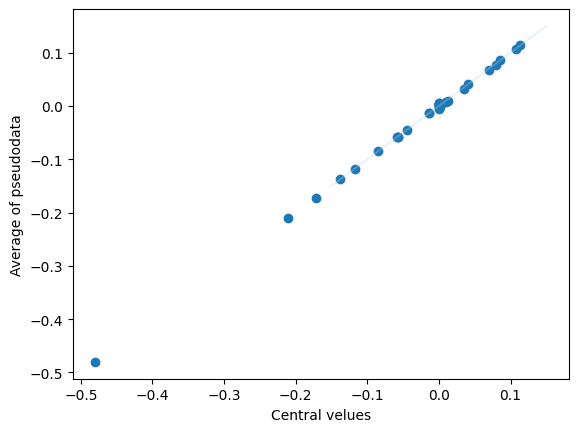

In [21]:
seed = 12413531412
HT = HTset(posteriors, P_tilde, x_nodes, True)
HT.generate_set(5000, seed, True)

In [22]:
pc_covmat = HT.covmat

In [23]:
from ht_utlis import H2_minus_abmp, H2_plus_abmp, Ht_minus_abmp, Ht_plus_abmp, H_2_abmp, H_L, H_T_abmp

In [25]:
ht_names

['H2p',
 'H2p',
 'H2p',
 'H2p',
 'H2p',
 'H2p',
 'H2p',
 'H2d',
 'H2d',
 'H2d',
 'H2d',
 'H2d',
 'H2d',
 'H2d',
 'HLp',
 'HLp',
 'HLp',
 'HLp',
 'HLp',
 'HLp',
 'HLp',
 'HLd',
 'HLd',
 'HLd',
 'HLd',
 'HLd',
 'HLd',
 'HLd',
 'H3p',
 'H3p',
 'H3p',
 'H3p',
 'H3p',
 'H3p',
 'H3p',
 'H3d',
 'H3d',
 'H3d',
 'H3d',
 'H3d',
 'H3d',
 'H3d']

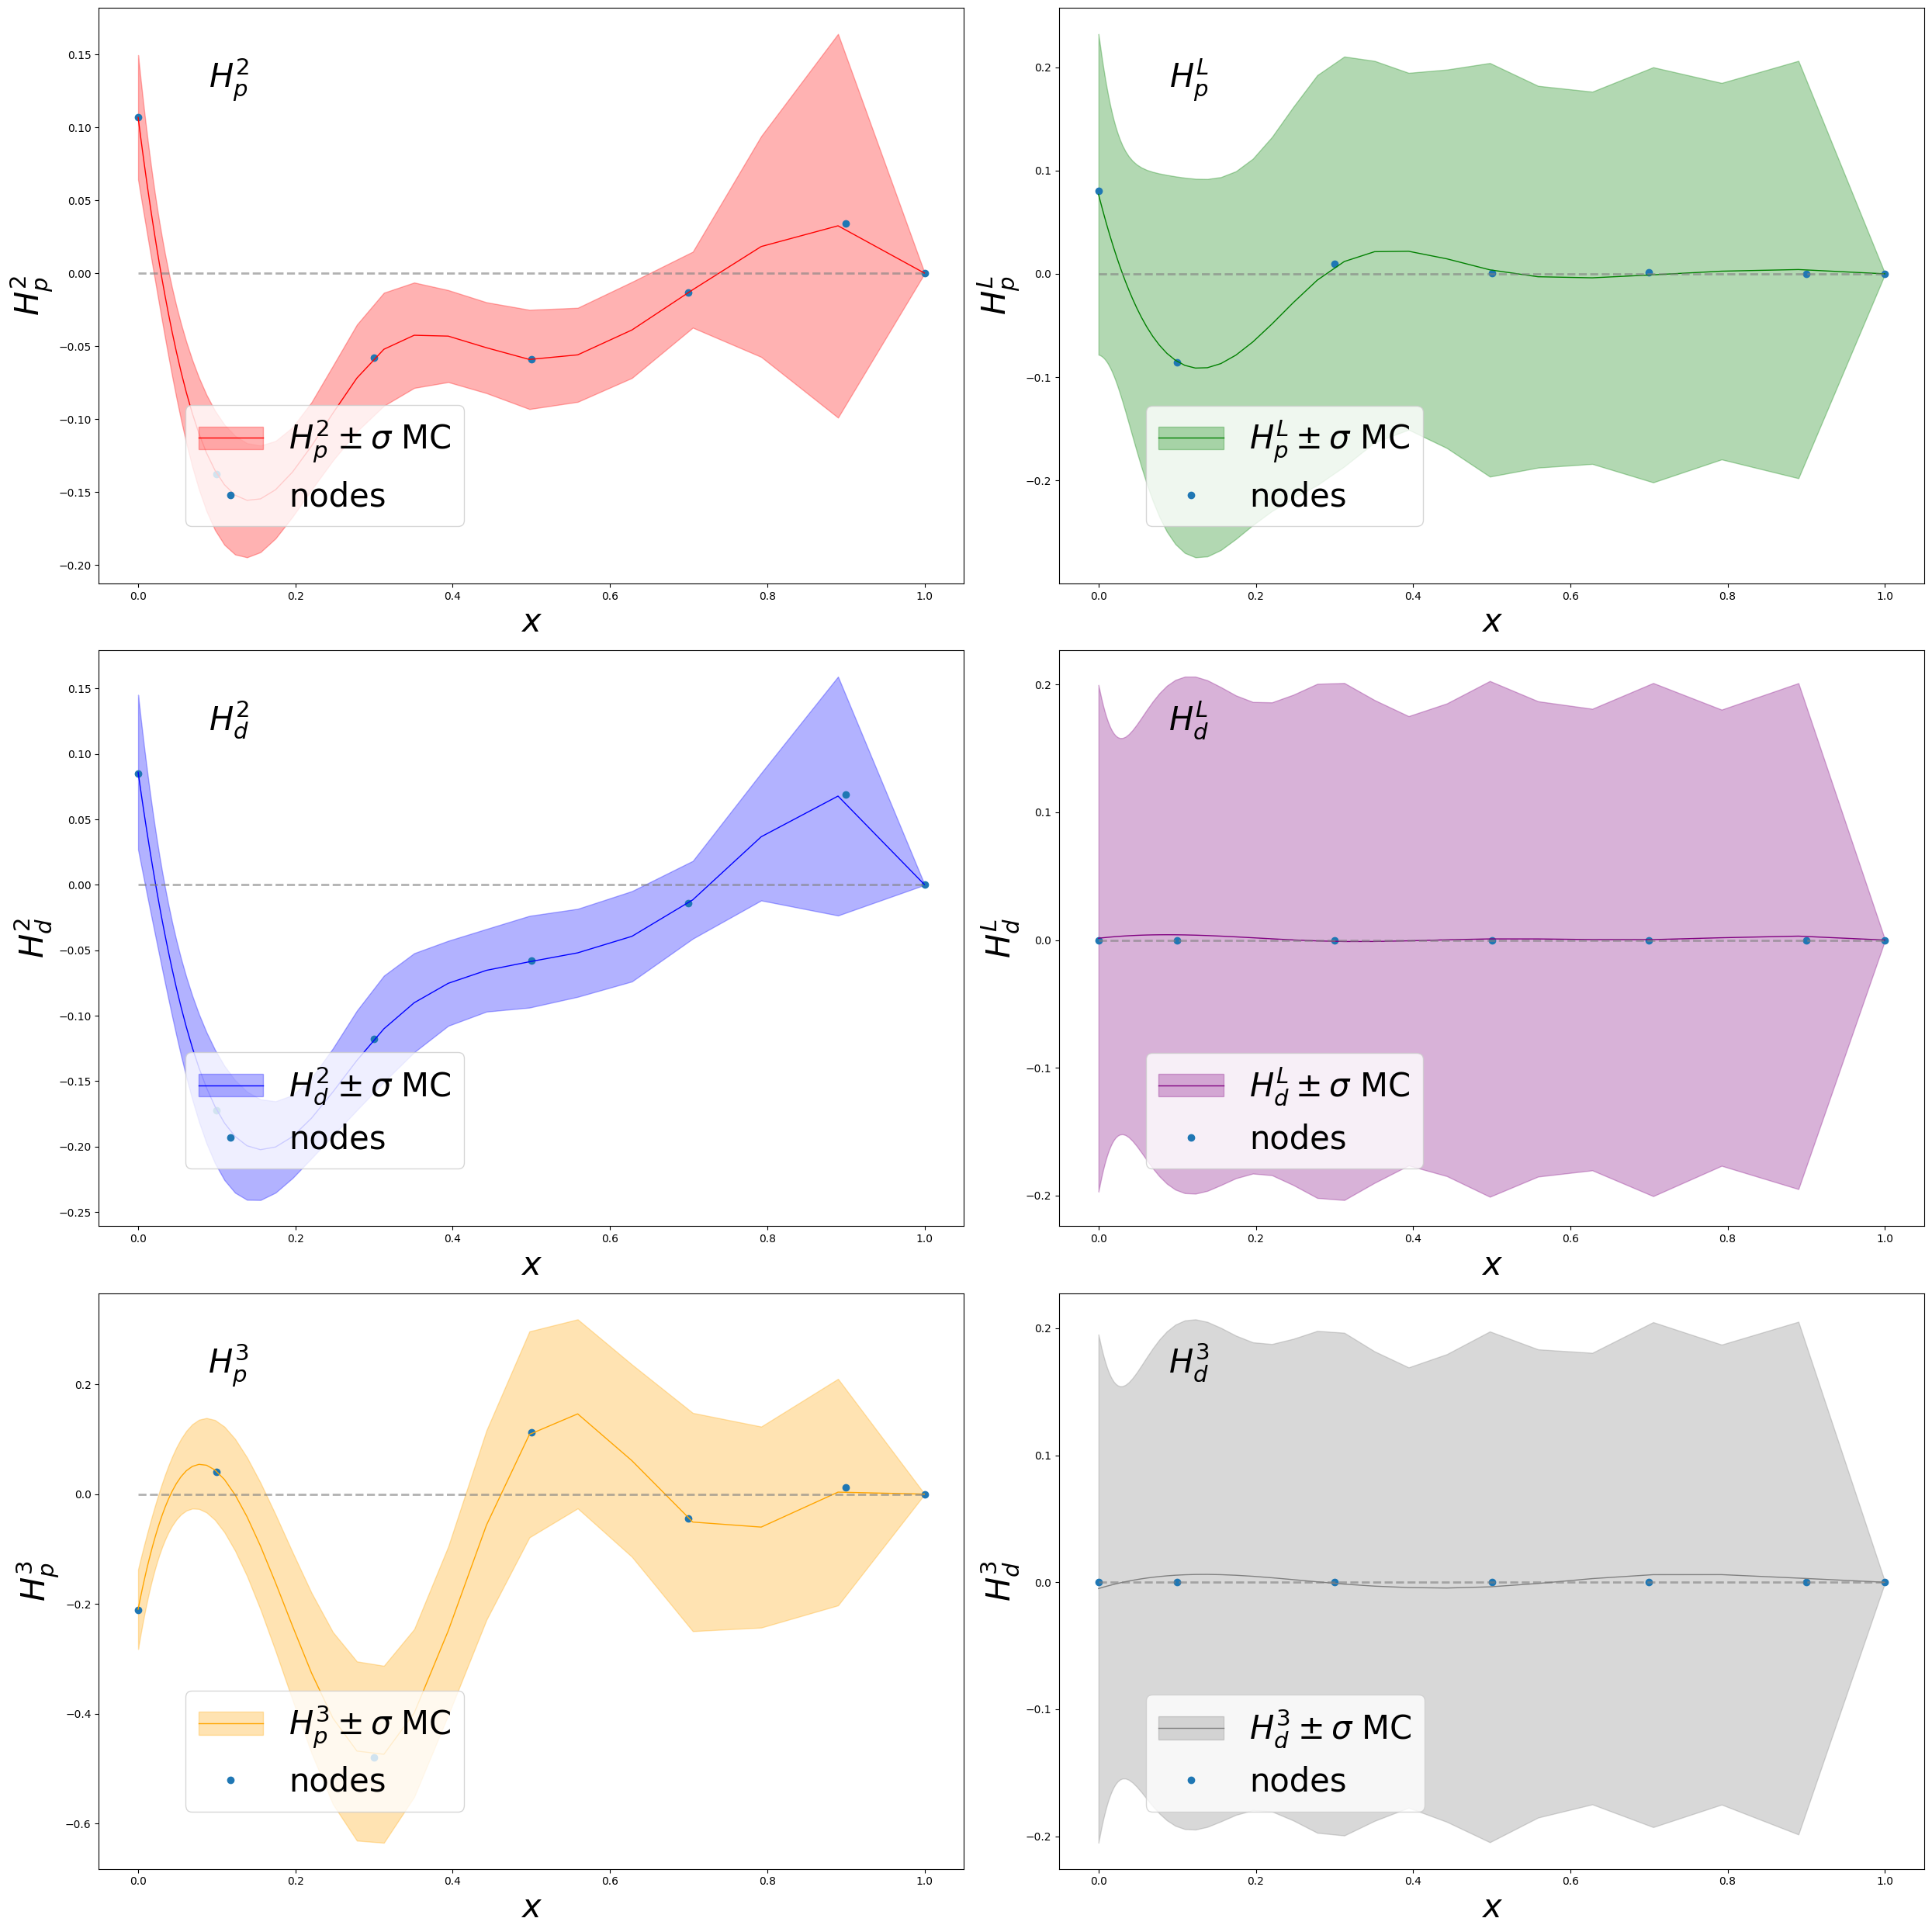

In [28]:
if len(pc_parameters) == 6:
  fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
  colors = ["red", "green", "blue", "purple", "orange", "grey"]
  keys = ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d"]
elif len(pc_parameters) == 7:
  fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
  colors = ["red", "green", "blue", "purple", "orange", "grey", "brown"]
  keys = ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d", "Hj"]
else:
  raise ValueError()

color = 'lightblue'
legends = []
legend_names = []
abmp = False

xv = np.logspace(-5, -0.0001, 100)

for idx_ax, (ax, key, color) in enumerate(zip(axs.flatten(), keys, colors)):
  htf = HT(xv, key)
  central = htf.mean(axis=1)
  std = htf.std(axis=1)

  central_nodes = np.concatenate([HT.central_nodes.xs(level="HT", key=key).to_numpy(), [0]])
  nodes = ax.plot(x_nodes[key], central_nodes, 'o', label='data')
  pl = ax.plot(xv, central, ls = "-", lw = 1, color = color)
  pl_lg = ax.fill(np.NaN, np.NaN, alpha = 0.3, color = pl[0].get_color()) # Necessary for fancy legend
  pl_fb  = ax.fill_between(xv, central - std, central + std , color = pl[0].get_color(),  alpha = 0.3)
  # Zero line
  ax.plot(xv, np.zeros_like(xv), ls = "dashed", lw = 2, color="grey", alpha=0.6)
  ax.set_xscale("log")
  ax.set_xlabel(f'$x$', fontsize = 30)
  ax.set_ylabel(rf"$H^{key[1]}_{key[2]}$", fontsize = 30)
  ax.set_title(rf"$H^{key[1]}_{key[2]}$", x = 0.15, y=0.85, fontsize=30)

  label = rf"$H^{key[1]}_{key[2]} \pm \sigma$ MC"
  ax.legend([(pl[0], pl_lg[0]), nodes[0]], [label, "nodes"], loc=[0.1, 0.1], fontsize=30)
  ax.set_xscale('log')

fig.tight_layout()
fig.savefig(save_dir + "/ht_plots.png")

for ax in axs.flatten():
  ax.set_xscale('linear')

fig.tight_layout()
fig.savefig(save_dir + "/ht_plots_linear.png")

for ax in axs.flatten():
  ax.set_xscale('log')

if abmp:
  axs[0][0].plot(xv, H_2_abmp(xv), ls = "-", lw = 1, color = 'blue', label="ABMP")
  axs[0][0].fill(np.NaN, np.NaN, color = 'blue', alpha = 0.3) # Necessary for fancy legend
  axs[0][0].fill_between(xv, H2_plus_abmp(xv), H2_minus_abmp(xv), color = 'blue', alpha = 0.3)
  axs[0][0].text(0.4, 0.9, "ABMP",transform=axs[0][0].transAxes, fontsize=40, color="blue")

  #HL_abmp = H_L(xv, H_2_abmp(xv), H_T_abmp(xv))
  #axs[0][1].plot(xv, HL_abmp, ls = "-", lw = 1, color = 'blue')
  #axs[0][1].fill(np.NaN, np.NaN, color = 'blue', alpha = 0.3) # Necessary for fancy legend
  #axs[0][1].fill_between(xv,
  #                       np.add(H2_plus_abmp(xv), -np.power(xv, 0.05) * Ht_plus_abmp(xv)),
  #                       np.add(H2_minus_abmp(xv), -np.power(xv, 0.05) * Ht_minus_abmp(xv)),
  #                       color = 'blue', alpha = 0.3)
  #axs[0][1].text(0.7, 0.9, "ABMP",transform=axs[0][1].transAxes, fontsize=40, color="blue")

fig.tight_layout()
fig.savefig(save_dir + "/comparison_abmp.png")

for ax in axs.flatten():
  ax.set_xscale('linear')

fig.tight_layout()
fig.savefig(save_dir + "/comparison_abmp_linear.png")

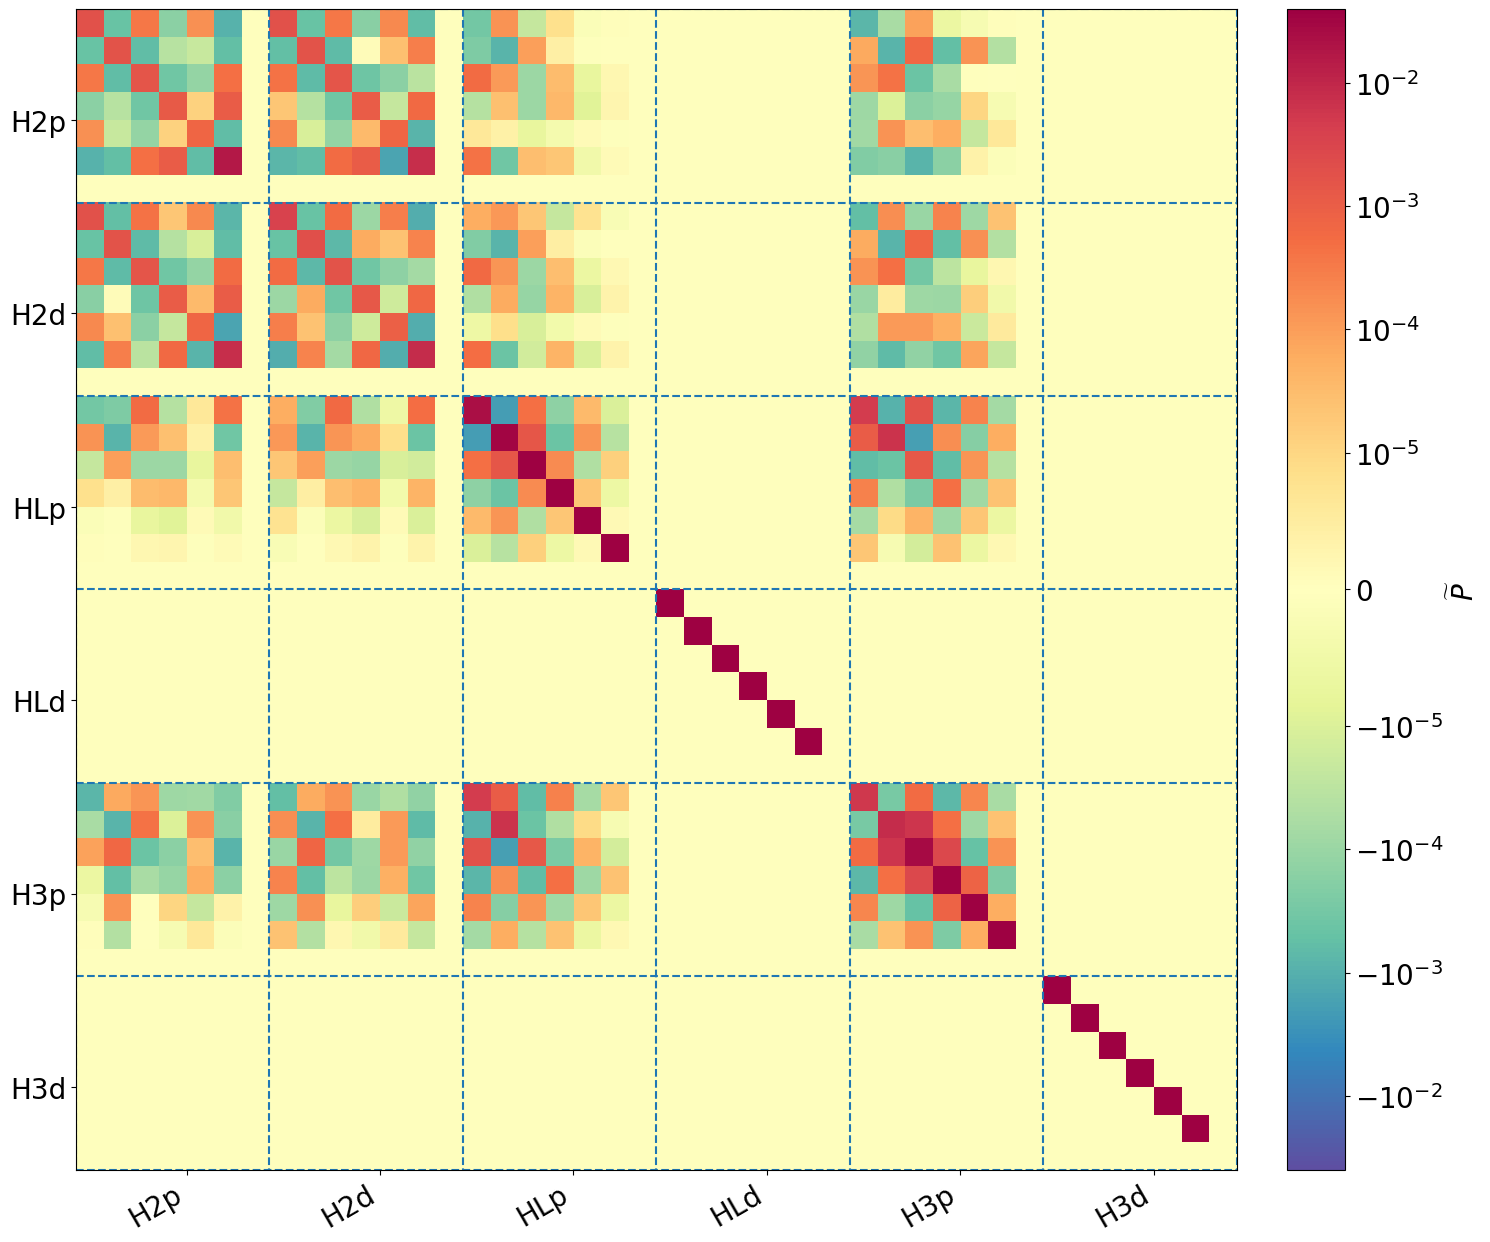

In [29]:
fig_matmap = plot_covmat_heatmap(P_tilde, "")

fig_matmap.tight_layout()
fig_matmap.savefig(save_dir + '/heatmap.png')

# TABLE

In [105]:
class Prediction:
  def __init__(self, central_preds, covmat, nodes, label, kin_label='x'):
    self.central_preds = central_preds
    self.covmat = covmat
    self.nodes = nodes
    self.label = label
    self.kin_label = kin_label

  #def __str__(self) -> str:
  #  return f"{self.central:.5f} ± {self.sigma:.3f}"
  
  def compute_diagonal_sigmas(self):
    return np.sqrt(self.covmat.diagonal())
  
  def build_table(self, save_fig=False):
    sigmas = self.compute_diagonal_sigmas()
    array = np.array([f"{central:.5f} ± {sigma:.3f}" for central, sigma in zip(self.central_preds, sigmas)])
    df = pd.DataFrame(array[np.newaxis, :], columns=[f"node {i+1} | {self.kin_label} = {self.nodes[i]}" for i in range(len(self.nodes))], index=[self.label])        
    #df.index = [self.label]
    fig_table, ax_posterior = plt.subplots(figsize=(10, 4))  # Set the figure size
    ax_posterior.axis('tight')
    ax_posterior.axis('off')  # Turn off the axis

    # Create a table plot from the DataFrame
    ax_posterior.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

    fig_table.tight_layout()
    if save_fig:
      save_dir_tables = Path(f"{save_dir}/tables")
      if not save_dir_tables.is_dir():
        save_dir_tables.mkdir(parents=True, exist_ok=True)
      fig_table.savefig(save_dir_tables / f"{self.label}_table.png")
  
    return fig_table
    


In [103]:
pred_H2p = Prediction(posteriors.xs("H2p", level="HT").to_numpy().reshape((-1)), P_tilde.xs("H2p", level="HT").T.xs("H2p", level="HT").to_numpy(), x_nodes['H2p'], 'H2p', 'x')
pred_HLp = Prediction(posteriors.xs("HLp", level="HT").to_numpy().reshape((-1)), P_tilde.xs("HLp", level="HT").T.xs("HLp", level="HT").to_numpy(), x_nodes['HLp'], 'HLp', 'x')
pred_H3p = Prediction(posteriors.xs("H3p", level="HT").to_numpy().reshape((-1)), P_tilde.xs("H3p", level="HT").T.xs("H3p", level="HT").to_numpy(), x_nodes['H3p'], 'H3p', 'x')
pred_H2d = Prediction(posteriors.xs("H2d", level="HT").to_numpy().reshape((-1)), P_tilde.xs("H2d", level="HT").T.xs("H2d", level="HT").to_numpy(), x_nodes['H2d'], 'H2d', 'x')
pred_HLd = Prediction(posteriors.xs("HLd", level="HT").to_numpy().reshape((-1)), P_tilde.xs("HLd", level="HT").T.xs("HLd", level="HT").to_numpy(), x_nodes['HLd'], 'HLd', 'x')
pred_H3d = Prediction(posteriors.xs("H3d", level="HT").to_numpy().reshape((-1)), P_tilde.xs("H3d", level="HT").T.xs("H3d", level="HT").to_numpy(), x_nodes['H3d'], 'H3d', 'x')



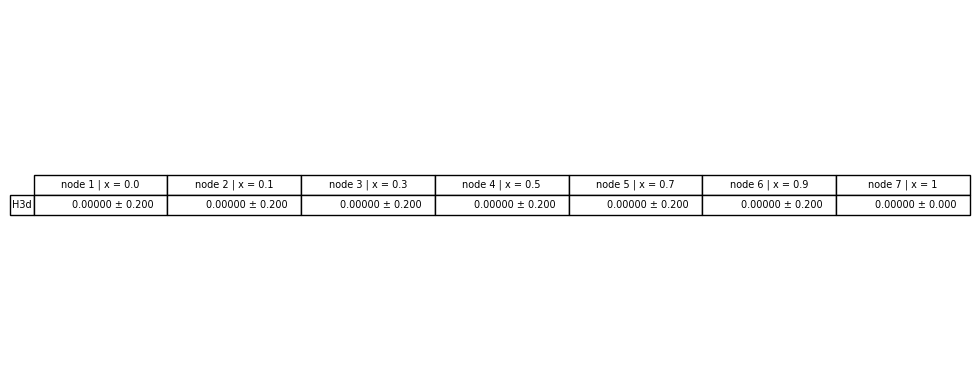

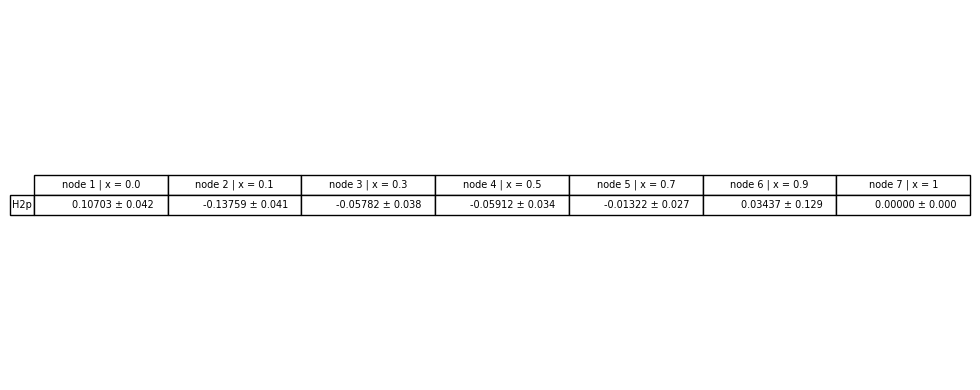

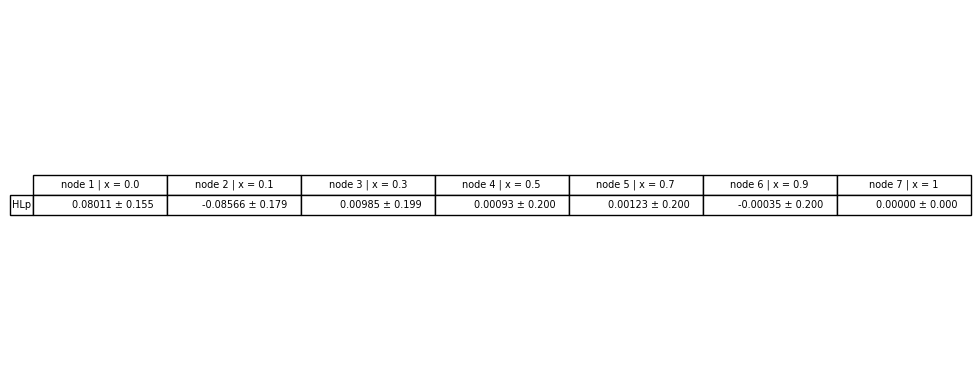

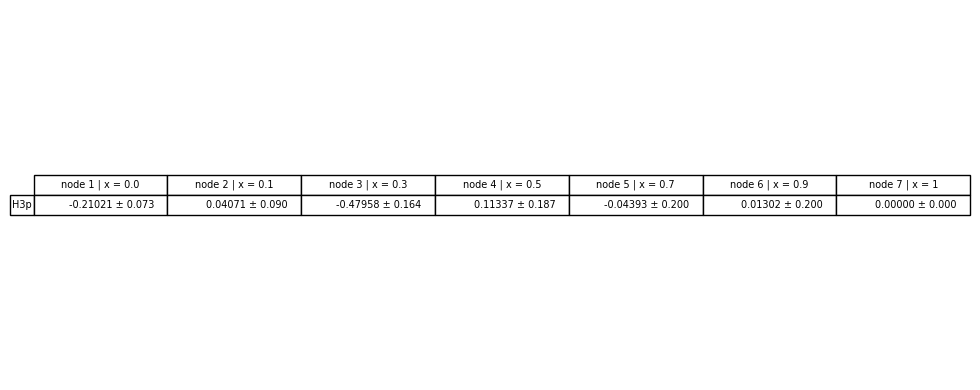

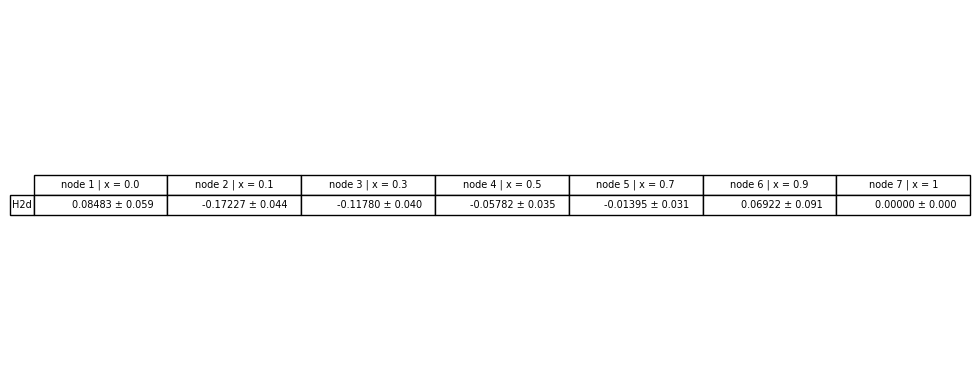

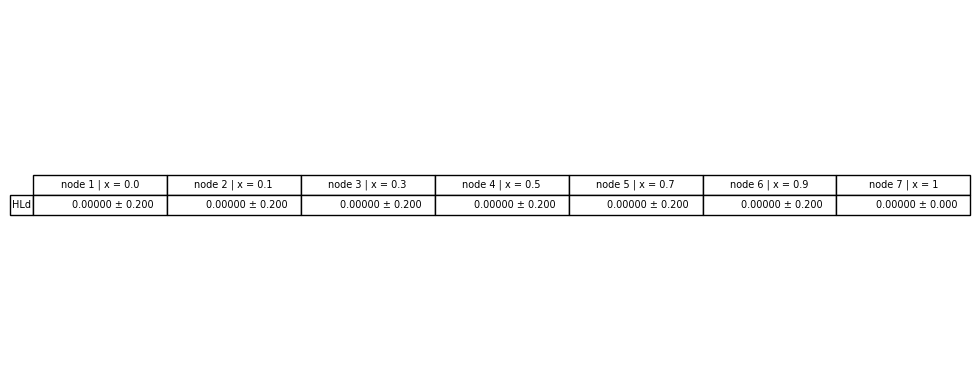

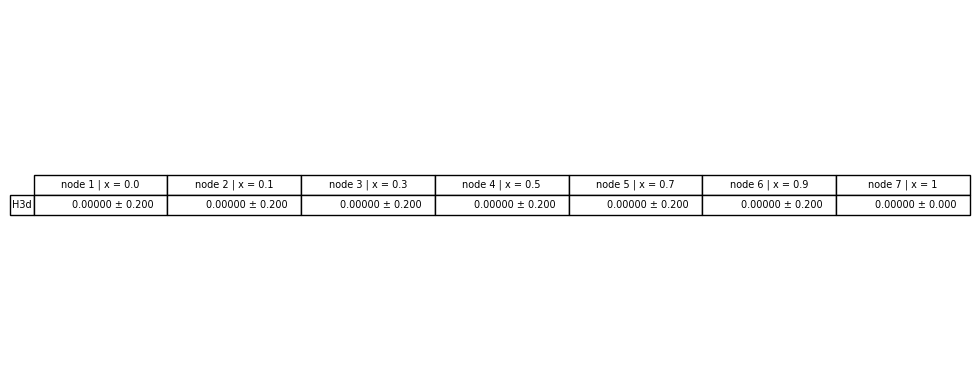

In [107]:
pred_H2p.build_table(True)
pred_HLp.build_table(True)
pred_H3p.build_table(True)
pred_H2d.build_table(True)
pred_HLd.build_table(True)
pred_H3d.build_table(True)